In [1]:
%matplotlib inline
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
rawdata_file1 = '../datatraining.csv'
rawdata_file2 = '../datatest.csv'

In [3]:
# Read in data, parsing the date column into datetime64 format, and combine
# train and test set into a single dataframe.

dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%y %H:%M')

occupancy_df = pd.read_csv(rawdata_file1, sep=";", parse_dates=True, index_col='date', date_parser=dateparse)
occupancy2_df = pd.read_csv(rawdata_file2, sep=";", parse_dates=True, index_col='date', date_parser=dateparse)

occupancy_df = pd.concat([occupancy_df, occupancy2_df], ignore_index=True)

In [4]:
occupancy_df.head()

,id,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,23.18,27.2720,426.0,721.25,0.004793,1
1,2,23.15,27.2675,429.5,714.00,0.004783,1
2,3,23.15,27.2450,426.0,713.50,0.004779,1
3,4,23.15,27.2000,426.0,708.25,0.004772,1
4,5,23.10,27.2000,426.0,704.50,0.004757,1


In [5]:
Y = np.array(occupancy_df['Occupancy'].values)
X = np.array(occupancy_df[['CO2', 'Light', 'Temperature', 'Humidity']])

# Get dimensions of input and output
dimof_output = int(np.max(Y) + 1)
dimof_input = X.shape[1]
print('dimof_input: ', dimof_input)
print('dimof_output: ', dimof_output)

# Scale/whiten the X data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Set y as categorical data
Y = np_utils.to_categorical(Y, dimof_output)

dimof_input:  4
dimof_output:  2


In [6]:
def create_dataset(X, Y, **options):
    """Convert an array of X, Y values into a dataset matrix for and LSTM"""
    
    look_back = options.pop('look_back', None)
    dataX, dataY = [], []
    for i in range(len(X) - look_back - 1):
        a = X[i:(i+look_back)]
        dataX.append(a)
        dataY.append(Y[i + look_back])
    return np.array(dataX), np.array(dataY)

def train_test_split_sequential(X, Y, **options):
    """Splits data into train test sets, based on a fraction test_size samples
    from the end of the timeseries"""
    
    test_size = options.pop('test_size', None)
    if test_size is None:
        test_size = 0.25
        
    n_sample = len(Y)
    n_test = int(n_sample * test_size)
        
    X_train = X[:-n_test]
    Y_train = Y[:-n_test]

    X_test = X[-n_test:]
    Y_test = Y[-n_test:]
    
    return X_train, X_test, Y_train, Y_test

# Predictions will be based on look_back minutes of data:
look_back = 45
X_all, Y_all = create_dataset(X, Y, look_back=look_back)

X_train, X_test, Y_train, Y_test = train_test_split_sequential(X_all, Y_all, test_size=0.25)

print('X training data shape = ', X_train.shape)
print('Y training data shape', Y_train.shape)

print('X test data shape = ', X_test.shape)
print('Y test data shape', Y_test.shape)

X training data shape =  (8072, 45, 4)
Y training data shape (8072, 2)
X test data shape =  (2690, 45, 4)
Y test data shape (2690, 2)


In [16]:
# Create the LSTM network.

batch_size = 32
dropout = 0.4

model = Sequential()
model.add(LSTM(output_dim=dimof_output))
model.add(Dropout(dropout))
model.add(Dense(50, init='uniform', activation='softmax'))
model.add(Dropout(dropout))
model.add(Dense(dimof_output, init='uniform', activation='softmax'))
model.compile(loss='mse', optimizer='rmsprop')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=2)`
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="softmax", kernel_initializer="uniform")`
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()


In [17]:
# Train model for num_epoch epochs, with an early stopping criterion.

num_epoch = 45

earlyStopping = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    callbacks=[earlyStopping],
    epochs=num_epoch, batch_size=32, verbose=1)

Train on 8072 samples, validate on 2690 samples
Epoch 1/45
8072/8072 [==============================] - 6s 722us/step - loss: 0.1987 - val_loss: 0.2375
Epoch 2/45
8072/8072 [==============================] - 5s 651us/step - loss: 0.1624 - val_loss: 0.2333
Epoch 3/45
8072/8072 [==============================] - 5s 674us/step - loss: 0.1408 - val_loss: 0.1812
Epoch 4/45
8072/8072 [==============================] - 6s 696us/step - loss: 0.1081 - val_loss: 0.1148
Epoch 5/45
8072/8072 [==============================] - 6s 737us/step - loss: 0.0830 - val_loss: 0.0727
Epoch 6/45
8072/8072 [==============================] - 5s 677us/step - loss: 0.0663 - val_loss: 0.0511
Epoch 7/45
8072/8072 [==============================] - 5s 672us/step - loss: 0.0581 - val_loss: 0.0392
Epoch 8/45
8072/8072 [==============================] - 5s 657us/step - loss: 0.0481 - val_loss: 0.0323
Epoch 9/45
8072/8072 [==============================] - 5s 655us/step - loss: 0.0456 - val_loss: 0.0286
Epoch 10/45
8072

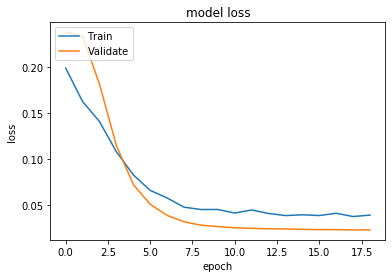

In [18]:
# Plot history for training and validation loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

10762/10762 [==============================] - 2s 190us/step


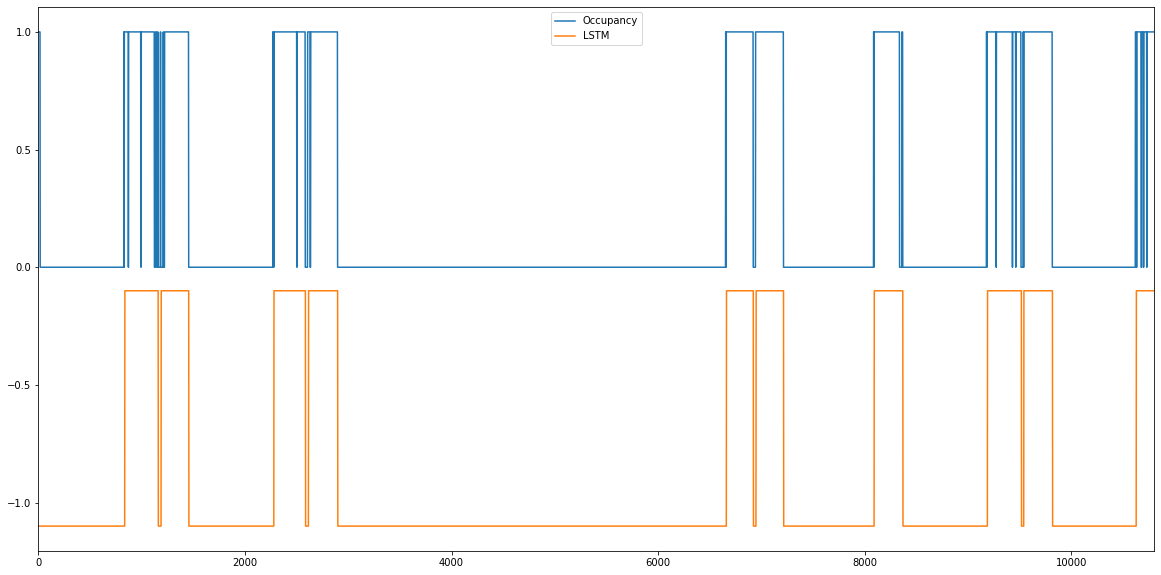

In [19]:
# Show model predictions against input occupancy labels, and input data timestreams

Y_predict = model.predict_classes(X_all, verbose=True)
series = np.hstack((np.zeros(look_back + 1, dtype=int), Y_predict))
occupancy_df['LSTM'] = pd.Series(series, index=occupancy_df.index)

occupancy_df['Occupancy'].plot(figsize=[20, 10], legend=True)
occupancy_df['LSTM'].apply(lambda x: x - 1.1).plot(legend=True)
#occupancy_df['CO2'].apply(lambda x: (x - 420.)/400. + 1).plot(legend=True)
#occupancy_df['Light'].apply(lambda x: x/450. + 2).plot(legend=True)
#occupancy_df['Temperature'].apply(lambda x: x - 15).plot(legend=True)
#occupancy_df['Humidity'].apply(lambda x: x / 5. ).plot(legend=True)

In [20]:
attributes = [col for col in occupancy2_df.columns if 
              #col == 'IsWorkDay' 
              #or col == 'Hour' 
              col == 'Light'
              #or col == 'IsWorkHour'
              or col == 'Temperature'
              #or col == 'date'
              or col == 'Humidity'
              or col == 'CO2'
              #or col == 'HumidityRatio'
             ]
X_testA = occupancy2_df[attributes].values
y_testA = occupancy2_df['Occupancy']

In [21]:
# Scale/whiten the X data
scaler = StandardScaler()
X = scaler.fit_transform(X_testA)

# Set y as categorical data
#Y = np_utils.to_categorical(y_testA, dimof_output)

In [22]:
look_back = 45
X_t, Y_t = create_dataset(X, y_testA, look_back=look_back)

In [23]:
Y_predict = model.predict_classes(X_t, verbose=True)

2619/2619 [==============================] - 0s 167us/step


In [24]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
print('Accuracy %s' % accuracy_score(Y_t, Y_predict))
print('F1-score %s' % f1_score(Y_t, Y_predict, average=None))
print(classification_report(Y_t, Y_predict))
confusion_matrix(Y_t, Y_predict)

Accuracy 0.7674684994272624
F1-score [0.83755668 0.59100067]
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1693
           1       0.78      0.48      0.59       926

    accuracy                           0.77      2619
   macro avg       0.77      0.70      0.71      2619
weighted avg       0.77      0.77      0.75      2619



array([[1570,  123],
       [ 486,  440]])